In [24]:
import numpy as np
import pandas as pd
import pickle
from joblib import dump, load
import matplotlib.pyplot as plt
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Activation, Dense, Dropout, Input, Embedding, Flatten, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.regularizers import L2
from tensorflow.config import list_physical_devices
from bayes_opt import BayesianOptimization

In [2]:
gpus = list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


# Load Data

In [3]:
df_train = pd.read_csv("X_train_stemm_cleaned.csv")
df_valid = pd.read_csv("X_valid_stemm_cleaned.csv")
df_test = pd.read_csv("X_test_stemm_cleaned.csv")

X_train_clean = df_train['tweet_stemming']
X_valid_clean = df_valid['tweet_stemming']
X_test_clean = df_test['tweet_stemming']

y_train = pd.read_csv("y_train.csv")
y_valid = pd.read_csv("y_valid.csv")
y_test = pd.read_csv("y_test.csv")

In [6]:
# For SparseCategoricalCrossentropy
with open('y_train_encoded.pkl', 'rb') as file:
    y_train_encoded = pickle.load(file)

with open('y_valid_encoded.pkl', 'rb') as file:
    y_valid_encoded = pickle.load(file)

with open('y_test_encoded.pkl', 'rb') as file:
    y_test_encoded = pickle.load(file)

In [7]:
# For CategoricalCrossentropy
y_train_encoded = pd.get_dummies(y_train, dtype=float)
y_valid_encoded = pd.get_dummies(y_valid, dtype=float)
y_test_encoded = pd.get_dummies(y_test, dtype=float)

# LSTM Using TF-IDF

In [8]:
# Load model TF-IDF
tfidf_vectorizer = load('tfidf_vectorizer.joblib')

# transform set data dari load model tfidf yang telah disimpan
X_train_tfidf = tfidf_vectorizer.transform(X_train_clean)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid_clean)
X_test_tfidf = tfidf_vectorizer.transform(X_test_clean)

C:\Users\andre\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\andre\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
X_train_tfidf.shape

(1270, 4216)

In [10]:
# Konversi sparse matrix ke dense array
X_train_dense = X_train_tfidf.toarray()
X_valid_dense = X_valid_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

In [11]:
# LSTM (timesteps = 1)
X_train_lstm = np.expand_dims(X_train_dense, axis=1)
X_valid_lstm = np.expand_dims(X_valid_dense, axis=1)
X_test_lstm = np.expand_dims(X_test_dense, axis=1)

## Define Model

In [47]:
# model LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu'))
model.add(LayerNormalization()),
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=L2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=L2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))  # Output layer, sesuai dengan jumlah kelas

# compile model
model.compile(loss=CategoricalCrossentropy(),  # cross entropy
              optimizer=Adam(learning_rate=0.0001),    # learning rate 0.0001
              metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [48]:
# train model
history = model.fit(X_train_lstm, y_train_encoded,
                    validation_data=(X_valid_lstm, y_valid_encoded),
                    epochs=50,  # Sesuaikan dengan jumlah epoch yang diperlukan
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=2)

Epoch 1/50
40/40 - 1s - loss: 1.2350 - accuracy: 0.3071 - val_loss: 1.2252 - val_accuracy: 0.3480 - 1s/epoch - 33ms/step
Epoch 2/50
40/40 - 0s - loss: 1.2199 - accuracy: 0.3748 - val_loss: 1.2214 - val_accuracy: 0.3663 - 235ms/epoch - 6ms/step
Epoch 3/50
40/40 - 0s - loss: 1.2098 - accuracy: 0.4016 - val_loss: 1.2170 - val_accuracy: 0.3846 - 230ms/epoch - 6ms/step
Epoch 4/50
40/40 - 0s - loss: 1.1971 - accuracy: 0.4535 - val_loss: 1.2116 - val_accuracy: 0.4029 - 231ms/epoch - 6ms/step
Epoch 5/50
40/40 - 0s - loss: 1.1862 - accuracy: 0.4677 - val_loss: 1.2050 - val_accuracy: 0.4286 - 227ms/epoch - 6ms/step
Epoch 6/50
40/40 - 0s - loss: 1.1731 - accuracy: 0.5110 - val_loss: 1.1965 - val_accuracy: 0.4579 - 225ms/epoch - 6ms/step
Epoch 7/50
40/40 - 0s - loss: 1.1468 - accuracy: 0.5528 - val_loss: 1.1868 - val_accuracy: 0.4615 - 227ms/epoch - 6ms/step
Epoch 8/50
40/40 - 0s - loss: 1.1269 - accuracy: 0.5803 - val_loss: 1.1745 - val_accuracy: 0.4762 - 229ms/epoch - 6ms/step
Epoch 9/50
40/40 -

<Axes: title={'center': 'Accuracy'}>

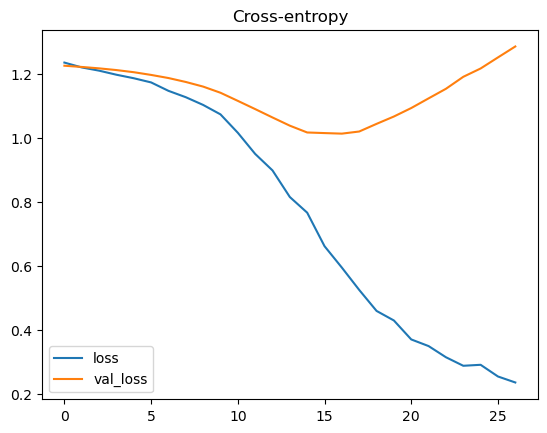

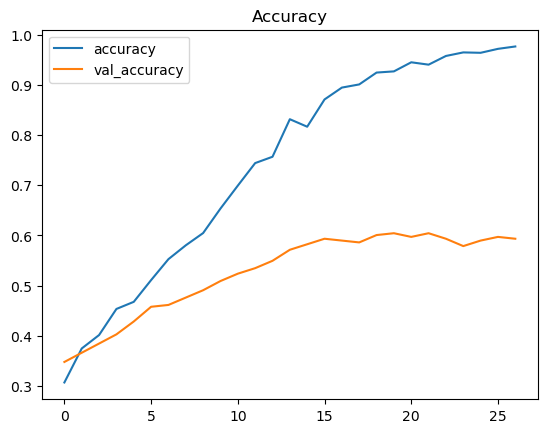

In [49]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [50]:
# evaluate model
y_pred = model.predict(X_test_lstm)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
label_ = ["negatif", "netral", "positif"]
print(classification_report(y_test_encoded.values.argmax(axis=1), y_pred_classes, target_names=label_))

9/9 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

     negatif       0.61      0.65      0.63        89
      netral       0.65      0.58      0.62        91
     positif       0.55      0.58      0.56        92

    accuracy                           0.60       272
   macro avg       0.61      0.60      0.60       272
weighted avg       0.61      0.60      0.60       272



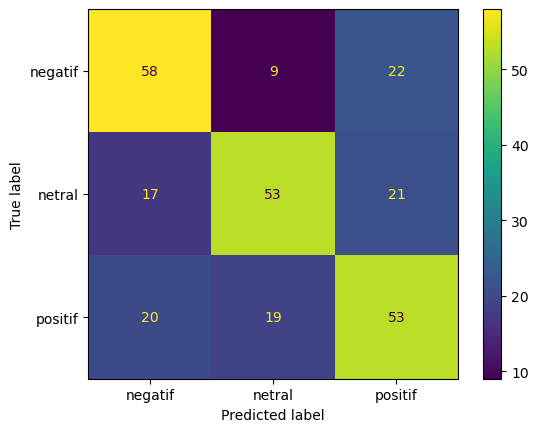

In [51]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded.values.argmax(axis=1), y_pred_classes, display_labels=label_)
plt.show()

## Save Model

In [52]:
# save model
model.save_weights(
    "lstm_tfidf"
)

In [53]:
# load model
model.load_weights('lstm_tfidf')

In [54]:
model.evaluate(X_test_lstm, y_test_encoded, verbose=0)

[0.9980061650276184, 0.6029411554336548]

# LSTM Using skipgram

In [41]:
# load model
word2vec_model = gensim.models.word2vec.Word2Vec.load("w2v_skipgram.model")

In [42]:
max_len = 50
# tok = Tokenizer(num_words=max_words)
tok = Tokenizer()
tok.fit_on_texts(X_train_clean)
sequences_train = tok.texts_to_sequences(X_train_clean)
sequences_matrix_train = pad_sequences(sequences_train,maxlen=max_len)

sequences_valid = tok.texts_to_sequences(X_valid_clean)
sequences_matrix_valid = pad_sequences(sequences_valid,maxlen=max_len)

sequences_test = tok.texts_to_sequences(X_test_clean)
sequences_matrix_test = pad_sequences(sequences_test,maxlen=max_len)

vocab_size = len(tok.word_index) + 1
print("Total words", vocab_size)

Total words 4231


In [43]:
# WORD2VEC
W2V_SIZE = 75
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tok.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        embedding_matrix[i] = np.zeros(W2V_SIZE)
print(embedding_matrix.shape)

(4231, 75)


## Define Model

In [61]:
# model LSTM
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=W2V_SIZE,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))  # Set to False to freeze the embeddings
model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu'))
model.add(LayerNormalization()),
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=L2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=L2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))  # Output layer, sesuai dengan jumlah kelas

# compile model
model.compile(loss=CategoricalCrossentropy(),  # cross entropy
              optimizer=Adam(learning_rate=0.0001),    # learning rate 0.0001
              metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [62]:
# train model
history = model.fit(sequences_matrix_train, y_train_encoded,
                    validation_data=(sequences_matrix_valid, y_valid_encoded),
                    epochs=50,  # Sesuaikan dengan jumlah epoch yang diperlukan
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=2)

Epoch 1/50
40/40 - 4s - loss: 1.5443 - accuracy: 0.3339 - val_loss: 1.2009 - val_accuracy: 0.3626 - 4s/epoch - 96ms/step
Epoch 2/50
40/40 - 3s - loss: 1.3564 - accuracy: 0.3449 - val_loss: 1.1731 - val_accuracy: 0.4615 - 3s/epoch - 74ms/step
Epoch 3/50
40/40 - 3s - loss: 1.2738 - accuracy: 0.3780 - val_loss: 1.1705 - val_accuracy: 0.4652 - 3s/epoch - 74ms/step
Epoch 4/50
40/40 - 3s - loss: 1.2319 - accuracy: 0.4055 - val_loss: 1.1662 - val_accuracy: 0.4908 - 3s/epoch - 77ms/step
Epoch 5/50
40/40 - 3s - loss: 1.2184 - accuracy: 0.4071 - val_loss: 1.1580 - val_accuracy: 0.4799 - 3s/epoch - 74ms/step
Epoch 6/50
40/40 - 3s - loss: 1.2303 - accuracy: 0.3906 - val_loss: 1.1548 - val_accuracy: 0.4799 - 3s/epoch - 73ms/step
Epoch 7/50
40/40 - 3s - loss: 1.1942 - accuracy: 0.4173 - val_loss: 1.1508 - val_accuracy: 0.4945 - 3s/epoch - 74ms/step
Epoch 8/50
40/40 - 3s - loss: 1.2007 - accuracy: 0.4299 - val_loss: 1.1495 - val_accuracy: 0.4908 - 3s/epoch - 74ms/step
Epoch 9/50
40/40 - 3s - loss: 1.

<Axes: title={'center': 'Accuracy'}>

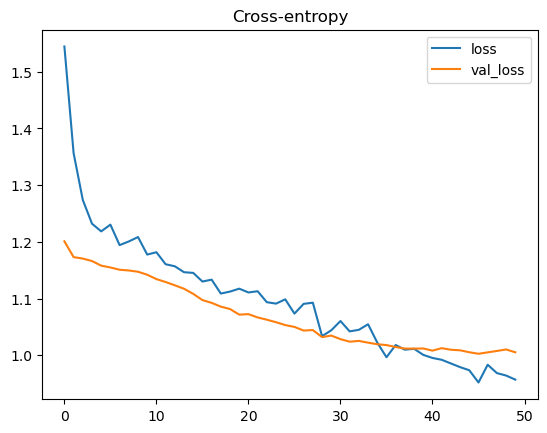

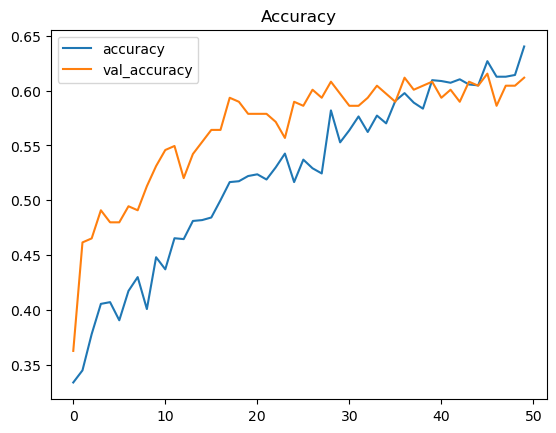

In [63]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [64]:
# evaluate model
y_pred = model.predict(sequences_matrix_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
label_ = ["negatif", "netral", "positif"]
print(classification_report(y_test_encoded.values.argmax(axis=1), y_pred_classes, target_names=label_))

9/9 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

     negatif       0.55      0.73      0.63        89
      netral       0.68      0.49      0.57        91
     positif       0.56      0.53      0.54        92

    accuracy                           0.58       272
   macro avg       0.60      0.59      0.58       272
weighted avg       0.60      0.58      0.58       272



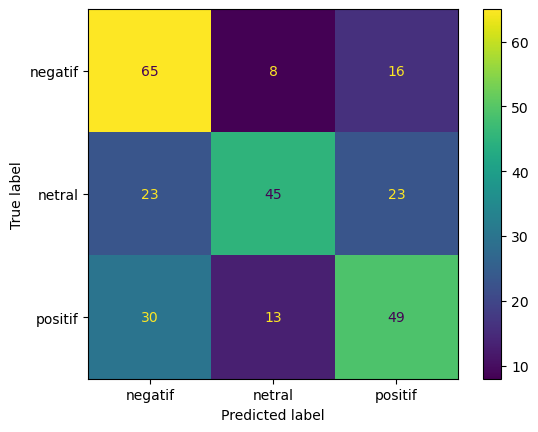

In [65]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded.values.argmax(axis=1), y_pred_classes, display_labels=label_)
plt.show()

## Save Model

In [66]:
# save model
model.save_weights(
    "lstm_word2vec"
)

In [68]:
# load model
model.load_weights('lstm_word2vec')

In [70]:
model.evaluate(sequences_matrix_test, y_test_encoded, verbose=0)

[0.9939942359924316, 0.5845588445663452]